In [1]:
# # pip install transformers
# from transformers import AutoModelForCausalLM, AutoTokenizer
# checkpoint = "HuggingFaceTB/SmolLM-135M-Instruct"

# device = "cpu" # for GPU usage or "cpu" for CPU usage
# tokenizer = AutoTokenizer.from_pretrained("gpt2", cache_dir="./.cache")

# # for multiple GPUs install accelerate and do `model = AutoModelForCausalLM.from_pretrained(checkpoint, device_map="auto")`
# model = AutoModelForCausalLM.from_pretrained(checkpoint, cache_dir="./.cache", max_length=100).to(device)

# # messages = [{"role": "user", "content": "List the steps to bake a chocolate cake from scratch."}]
# # input_text=tokenizer.apply_chat_template(messages, tokenize=False)
# input_text = format_input(data[50])
# print(input_text)
# inputs = tokenizer.encode(input_text, return_tensors="pt").to(device)
# # outputs = model(inputs)
# # print(outputs)
# outputs = model.generate(inputs, max_new_tokens=100, temperature=0.6, top_p=0.92, do_sample=True, output_scores=True, return_dict_in_generate=True)
# print(outputs)
# # print(outputs.scores)
# # print(tokenizer.decode(outputs[0]))


# Prepare dataset

In [2]:
# Read data
import json
file_path = "instruction-data.json"

with open(file_path, "r") as file:
        data = json.load(file)

In [3]:
print(data[0])

{'instruction': 'Evaluate the following phrase by transforming it into the spelling given.', 'input': 'freind --> friend', 'output': 'The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".'}


In [4]:
import torch
from torch.utils.data import Dataset

# Apply alpaca prompt style
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )
    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
    return instruction_text + input_text

In [5]:
model_input = format_input(data[0])
desired_response = f"\n\n### Response:\n{data[50]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Evaluate the following phrase by transforming it into the spelling given.

### Input:
freind --> friend

### Response:
The correct spelling is 'Occasion.'


In [6]:
# Partitioning the dataset

train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1) # 10%
val_portion = len(data) - train_portion - test_portion # 5%

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


In [7]:
# Batching the dataset

class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

In [8]:
# Get eos token id (will be used for padding also)

from transformers import AutoModelForCausalLM, AutoTokenizer

checkpoint = "HuggingFaceTB/SmolLM-360M-Instruct"
tokenizer = AutoTokenizer.from_pretrained(checkpoint, cache_dir="./.cache")

print(tokenizer.eos_token_id)
print(tokenizer.vocab_size)

tokenizer_config.json:   0%|          | 0.00/3.59k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

2
49152


In [9]:
# Custom collate function

def custom_collate_fn(
    batch,
    pad_token_id=tokenizer.eos_token_id,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] * 
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        # New: Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # New: Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [10]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

print(custom_collate_fn(batch))

(tensor([[0, 1, 2, 3, 4],
        [5, 6, 2, 2, 2],
        [7, 8, 9, 2, 2]]), tensor([[   1,    2,    3,    4, -100],
        [   6,    2, -100, -100, -100],
        [   8,    9,    2, -100, -100]]))


In [11]:
if torch.cuda.is_available():
    device = "cuda"
# elif torch.backends.mps.is_available():
#     device = "mps"
else:
    device = "cpu"
    
print("Device:", device)

Device: cuda


In [12]:
from functools import partial
customized_collate_fn = partial(custom_collate_fn, device=device, allowed_max_length=1024)

In [13]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [14]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 74]) torch.Size([8, 74])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 63]) torch.Size([8, 63])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 78]) torch.Size([8, 78])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 70]) torch.Size([8, 70])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 69]) torch.

# Load pretrained model

In [15]:
model = AutoModelForCausalLM.from_pretrained(checkpoint, cache_dir="./.cache", max_length=100).to(device)

config.json:   0%|          | 0.00/736 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/724M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

In [16]:
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [17]:
inputs = tokenizer.encode(input_text, return_tensors="pt").to(device)
outputs = model.generate(inputs, max_new_tokens=100, temperature=0.6, top_p=0.92, do_sample=True, output_scores=True, return_dict_in_generate=True)
outputs = tokenizer.decode(outputs.sequences[0])
print(outputs)

/lunit/home/pytholic/miniconda3/envs/llm_smollm/lib/python3.11/site-packages/transformers/generation/utils.py:1376: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Response:
The chef cooks the meal every day.

The chef is cooking the meal every day.

The chef cooks the meal every day.

The chef is cooking the meal every day.

The chef is cooking the meal every day.

The chef is cooking the meal every day.

The chef is cooking the meal every day.

The chef is cooking the meal every day.

The chef is cooking the meal every day


# Finetuning the model

In [18]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    outputs = model(input_batch)
    logits = outputs.logits 
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

def train_model_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs,
    eval_freq,
    eval_iter,
    start_context,
    tokenizer,
):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()  # Calculate loss gradients
            optimizer.step()  # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(
                    f"Ep {epoch+1} (Step {global_step:06d}): "
                    f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}"
                )

        # Print a sample text after each epoch
        generate_and_print_sample(model, tokenizer, device, start_context)

    return train_losses, val_losses, track_tokens_seen

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = 1024
#     inputs = tokenizer.encode(input_text, return_tensors="pt").to(device)
# outputs = model.generate(inputs, max_new_tokens=100, temperature=0.6, top_p=0.92, do_sample=True, output_scores=True, return_dict_in_generate=True)
# outputs = tokenizer.decode(outputs.sequences[0])
# print(outputs)
    encoded = tokenizer.encode(start_context, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model.generate(encoded, max_new_tokens=100, temperature=0.6, top_p=0.92, do_sample=True)
        decoded_text = tokenizer.decode(outputs[0])
        print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [19]:
# check the initial loss

model.to(device)
torch.manual_seed(123)
 
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
 
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


Training loss: 2.4040127277374266
Validation loss: 2.3871003150939942


In [20]:
# Train the model

import time
 
start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00004, weight_decay=0.1)
num_epochs = 5
 
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)
 
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 1.937, Val loss 1.914
Ep 1 (Step 000005): Train loss 0.912, Val loss 0.859
Ep 1 (Step 000010): Train loss 0.598, Val loss 0.703
Ep 1 (Step 000015): Train loss 0.602, Val loss 0.661
Ep 1 (Step 000020): Train loss 0.536, Val loss 0.657
Ep 1 (Step 000025): Train loss 0.571, Val loss 0.634
Ep 1 (Step 000030): Train loss 0.636, Val loss 0.617
Ep 1 (Step 000035): Train loss 0.579, Val loss 0.603
Ep 1 (Step 000040): Train loss 0.505, Val loss 0.595
Ep 1 (Step 000045): Train loss 0.473, Val loss 0.581
Ep 1 (Step 000050): Train loss 0.504, Val loss 0.575
Ep 1 (Step 000055): Train loss 0.592, Val loss 0.569
Ep 1 (Step 000060): Train loss 0.564, Val loss 0.556
Ep 1 (Step 000065): Train loss 0.498, Val loss 0.549
Ep 1 (Step 000070): Train loss 0.440, Val loss 0.545
Ep 1 (Step 000075): Train loss 0.449, Val loss 0.543
Ep 1 (Step 000080): Train loss 0.473, Val loss 0.542
Ep 1 (Step 000085): Train loss 0.419, Val loss 0.539
Ep 1 (Step 000090): Train loss 0.404, Val loss

In [21]:
# Plot the loss
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

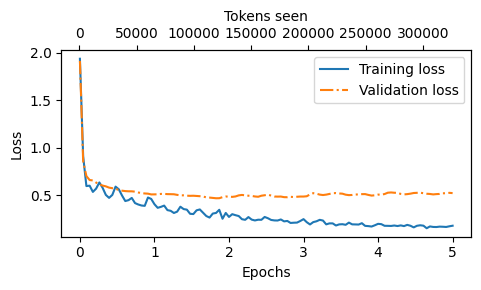

In [22]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [23]:
# Test some responses

torch.manual_seed(123)

for entry in test_data[:3]:

    input_text = format_input(entry)
    encoded = tokenizer.encode(input_text, return_tensors="pt").to(device)
    outputs = model.generate(encoded, max_new_tokens=256, do_sample=False)
    # outputs = model.generate(encoded, max_new_tokens=256, temperature=0.6, top_p=0.92, do_sample=True)
    decoded_text = tokenizer.decode(outputs[0])
    print(decoded_text.replace("\n", " "))  # Compact print format
    response_text = (
        decoded_text[len(input_text):]
        .replace("### Response:", "")
        .replace(tokenizer.eos_token, "")
        .strip()
    )

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.  ### Instruction: Rewrite the sentence using a simile.  ### Input: The car is very fast.  ### Response: The car is as fast as a cheetah.<|im_end|>
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a cheetah.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.  ### Instruction: What type of cloud is typically associated with thunderstorms?  ### Response: The type of cloud typically associated with thunderstorms is cumulus clouds.<|im_end|>
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instru

# Saving model and responses for evaluation

In [24]:
# Save all responses for future evaluations

import json
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    input_text = format_input(entry)
    encoded = tokenizer.encode(input_text, return_tensors="pt").to(device)
    outputs = model.generate(encoded, max_new_tokens=256, do_sample=False)
    decoded_text = tokenizer.decode(outputs[0])
    response_text = (
        decoded_text[len(input_text):]
        .replace("### Response:", "")
        .replace(tokenizer.eos_token, "")
        .strip()
    )

    test_data[i]["model_response"] = response_text


with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)  # "indent" for pretty-printing

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:48<00:00,  2.28it/s]


In [25]:
# import re

# file_name = "smollm-sft-epoch-5.pth"
# torch.save(model.state_dict(), file_name)
# print(f"Model saved as {file_name}")